In [1]:
%load_ext autoreload
%autoreload 2

# TIP5P Water 
## Here, we will briefly analyze the response functions in TIP5P.

In [2]:
import ThermoFit as therm
import OneDFit as od
import numpy as np
import matplotlib.pyplot as plt

tc, pc, rhoc = 213., 338., 0.0595
mys = od.SpinodalFit("./Data/compiledEOSAll",230.)
mys.setCriticalPt(tc,pc,rhoc)
mys.fitParams["A(T) params"] = np.array([  5.62586691e-06,  -2.43215926e-05,   1.70903857e-04,
        -2.05070945e-04])[::-1]
mys.fitParams["P(T) params"] = np.array([ -496.40292951,  1503.16997588, -1632.66291085])[::-1] 
#unit conversion #unit conversion S2,S1,S0
fn = "./Data/current_fit_x2_06"
fn2 = "./current_fit"
Model = therm.ThermoPPty(fn2,Tc=tc,Pc=pc,Rhoc=rhoc,spinodal=mys)

In [3]:
x = np.loadtxt(fn2)
Model.setValues(x,interaction=True)
print(Model.__str__(T=320.1,P=139.98))
print(Model.getPressure(T=320.1,Density=1040.))

import pandas as pd
import numpy as np


fig, ax = plt.subplots(1,1)
import matplotlib.pyplot as plt
results = [[T,p,Model.getDensity(P=p,T=T),Model.getCompressibility(P=p,T=T)]
               for T in np.linspace(210,340,100) for p in np.linspace(-300.,500,100)]
df = pd.DataFrame(results,columns=['T','P','density','Kt'])
#df.index = df['T']
#df.groupby('density').plot(marker='*',ax=ax,label=p)
#plt.ylim([2500.,7000.])
#plt.ylabel('Density')
#ax.legend(loc='best',ncol=6)
#plt.show()
df.head()

<At this given state with T=320.100000 and P=139.980000, the response functions are the following>		
Density is 1003.395000 kg/m^3
c_P is 7340.423504 J.(kgK)^-1
c_V is 5947.460970 J.(kgK)^-1
k_T is 0.000623 MPa^-1
alpha_p		is 0.001650 K^-1
c_s is 1.404916

[ 194.62445106]


,T,P,density,Kt
0,210.0,-300.000000,602.939308,0.002351
1,210.0,-291.919192,614.451105,0.002330
2,210.0,-283.838384,626.073172,0.002308
3,210.0,-275.757576,637.797409,0.002284
4,210.0,-267.676768,649.615221,0.002260


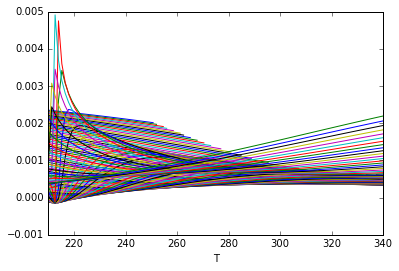

In [6]:
fig,ax=plt.subplots()
gdf = df.groupby('P')
for key,item in gdf: item.plot(x='T',y='Kt',ax=ax,label=key)
ax.legend_.remove()
plt.show()

In [8]:
# groupby Pressure and define function for calculation
import pandas as pd
from scipy.interpolate import UnivariateSpline
import matplotlib.pyplot as plt

# sign -1 means max
def findextrema(df,sign,name):
    Obs=df.sort_values(by='T').as_matrix(['T',name])
    xs,ys = Obs[:,0],Obs[:,1]
    spl = UnivariateSpline(xs,ys,k=4,s=0.)
    myroots = spl.derivative().roots()
    
    count = 0
    td2ydx2 = -np.inf*sign
    resx, resy = np.nan, np.array([np.nan])
    for r in myroots:
        y, dydx, d2ydx2 = spl(r,0), spl(r,1), spl(r,2)
        if (sign*d2ydx2 > sign*0.0000000000001):
            count += 1
            if (sign*td2ydx2 < sign*d2ydx2 ):
                resx, resy = r, y
                #td2ydx2 = d2ydx2
                
    return pd.DataFrame({'T':resx, 'P' : df['P'].unique()},index=df['P'].unique())
#ddf.apply(findmaxdensity)


ddg = df[df['P']==-300.]
findextrema(ddg,-1,'density')


,P,T
-300.0,-300.0,329.77323


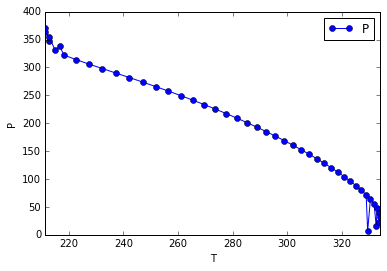

In [9]:
# HDL spinodal
HDLspinodal = gdf.apply(findextrema,-1,'Kt')
HDLspinodal.dropna().sort_values(by='T').plot(x='T',y='P',marker='o')
plt.ylabel('P')
plt.show()

In [10]:
ddf = df.groupby('P')
dTmin = ddf.apply(findextrema, 1,'density')
dTmax = ddf.apply(findextrema,-1,'density')
dKtmax = ddf.apply(findextrema, -1,'Kt')
dKtmin = ddf.apply(findextrema, 1,'Kt')

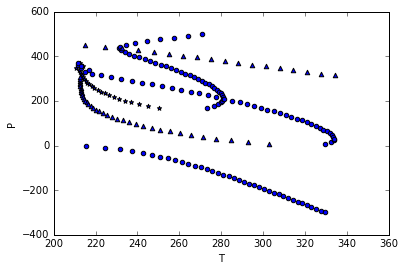

In [11]:
# Visualize
fig,ax = plt.subplots(1,1)
dTmax.dropna(inplace=True,axis=0)
dTmin.dropna(inplace=True,axis=0)
dKtmax.dropna(inplace=True,axis=0)
dKtmin.dropna(inplace=True,axis=0)
dTmax.sort_values(by='T').plot(x='T',y='P',kind='scatter',ax=ax)
dTmin.sort_values(by='T').plot(x='T',y='P',kind='scatter',ax=ax,marker='*')
dKtmax.sort_values(by='T').plot(x='T',y='P',kind='scatter',ax=ax,marker='+')
dKtmin.sort_values(by='T').plot(x='T',y='P',kind='scatter',ax=ax,marker='^')
HDLspinodal.dropna().sort_values(by='T').plot(x='T',y='P',kind='scatter',marker='o',ax=ax)
#dTmin.dropna(inplace=True,axis=0).sort_values(by='T').plot(x='T',y='P',kind='scatter',ax=ax)
plt.show()

In [11]:
dTmax.reset_index(drop=True,inplace=True)
dTmax['Feature'] = 'Tmax'
dTmin.reset_index(drop=True,inplace=True)
dTmin['Feature'] = 'Tmin'
dKtmax.reset_index(drop=True,inplace=True)
dKtmax['Feature'] = 'Ktmax'
dKtmin.reset_index(drop=True,inplace=True)
dKtmin['Feature'] = 'Ktmin'

AllT= dTmax.append(dTmin)
AllK = dKtmax.append(dKtmin)
All = AllT.append(AllK)
All['Source'] = 'TSEOS'
All.to_csv('../src/ScalingWaterModels/FeaturesTIP5P.dat', sep='\t',index=False)

In [70]:
# parameters for TIP4P2005
nLs, nWs , nBg, delw, f = 5, 1, 12, 1., 0.
x=np.zeros(nLs+nWs+nBg)
x[0:nLs]=1.55607,0.154014,0.125093,0.00854418, 1.14576
x[nLs:nLs+nWs]=0.03
x[nLs+nWs:nLs+nWs+nBg] = [-0.00261876, 0.257249, -6.30589, 0.000605678,
0.0248091, -0.0400033, 2.18819, -0.000994166, -0.00840543, 0.0719058, -0.256674, 0.]

In [71]:
tc, pc, rhoc = 182., 170., 0.05645
mys = od.SpinodalFit("./Data/compiledEOSAllTIP4P2005",182.)
mys.setCriticalPt(tc,pc,rhoc)
mys.fitParams["A(T) params"] = np.poly1d([-0.0822462,-0.0547873]) #A1, A0
mys.fitParams["P(T) params"] = np.poly1d([-0.0065*tc*tc,2.61*tc,-462.]) #unit conversion S2,S1,S0
Model = therm.ThermoPPty("./Data/compiledEOSAllTIP4P2005",Tc=tc,Pc=pc,Rhoc=rhoc,spinodal=mys)

In [14]:
Model.setValues(x,interaction=True)
print(Model.__str__(T=200.,P=100.))

<At this given state with T=200.000000 and P=100.000000, the response functions are the following>		
Density is 984.965864 kg/m^3
c_P is 7935.776379 J.(kgK)^-1
c_V is 5143.479851 J.(kgK)^-1
k_T is 0.001250 MPa^-1
alpha_p		is -0.004145 K^-1
c_s is 1.119581



In [26]:
import pandas as pd
import numpy as np
results = [[T,Model.getCp(P=301.,T=T)] for T in np.linspace(180,300,50)]

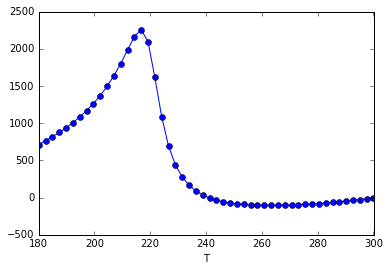

,T,Cp
T,,
180.000000,180.000000,713.447618
182.448980,182.448980,763.420269
184.897959,184.897959,817.149127
187.346939,187.346939,875.260286
189.795918,189.795918,938.437779


In [27]:
df = pd.DataFrame(results,columns=['T','Cp'])
df.index = df['T']
import matplotlib.pyplot as plt
df['Cp'].plot(marker='o')
#plt.ylim([2500.,7000.])
plt.show()
df.head()

In [1]:
import pandas as pd
import numpy as np

In [21]:
fn='./Data/compiledEOSCVAllshort'
fn = './Data/collatedCV'#'./Data/compiledEOSCV50'
df = pd.read_csv(fn,sep='\t')
df.head()
#df[df[['Cv']] == "Folarin"] = np.nan
df.sample(10)

,Temperature,Density,Cv
45,230,940,4937.14
369,320,940,5921.45
207,275,940,9063.55
71,235,1080,6898.56
191,270,980,8703.32
363,315,1140,4864.81
181,265,1100,6182.22
101,245,980,10292.74
10,215,1070,7168.33
172,265,960,9885.97


In [22]:
df.dropna(inplace=True)
df=df[df>0]
fn = './Data/prunedcompiledEOSCV'
df.to_csv(fn,sep='\t',index=False)
df['Cv']=pd.to_numeric(df['Cv'],errors='coerce')
dfg = df.groupby('Density')
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 403 entries, 0 to 402
Data columns (total 3 columns):
Temperature    403 non-null int64
Density        403 non-null int64
Cv             403 non-null float64
dtypes: float64(1), int64(2)
memory usage: 12.6 KB


18


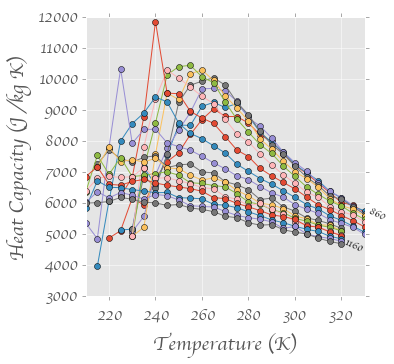

In [24]:
import matplotlib.pyplot as plt
plt.style.use('ggplot')
fig, ax = plt.subplots(figsize=(5,5))
#fig.set_size_inches(4, 6)
plt.rcParams["font.family"] = "cursive"
i=0
maxd = df['Density'].max()
mind = df['Density'].min()
count=0
for key, item in dfg:
    if key > 0. : 
        item[item['Temperature']>200.].sort_values(by='Temperature').plot(x='Temperature',y='Cv',marker='o',ax=ax,label=key)
        loc = item.loc[item['Temperature'].argmax(),['Temperature','Cv']]
        count+=1
        if key in [maxd,mind]: plt.annotate('{:4.0f}'.format(key),xy=loc, fontsize=10,rotation=-25)
ax.legend_.remove()
plt.xlabel('Temperature (K)', fontsize=20)
plt.ylabel('Heat Capacity (J /kg K)',fontsize=20)
plt.tick_params(axis='both', which='major', labelsize=16)
print(count)
plt.show()
#plt.savefig('./Data/myCv50.pdf',dpi=300,bbox_inches='tight')

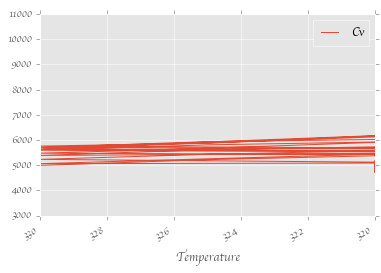

In [18]:
df.plot(x='Temperature',y='Cv',subplots=True,by='Density')
plt.show()

In [12]:
# Take a look at compiledEOS25ns
df = pd.read_csv('./Data/pruned025compiledEOSAll',sep='\t')

In [13]:
df.columns = ['T','P','rho']
df.head()

,T,P,rho
0,330.0,157.570,1040.0
1,325.0,149.266,1040.0
2,320.0,140.359,1040.0
3,315.0,133.277,1040.0
4,310.0,126.145,1040.0


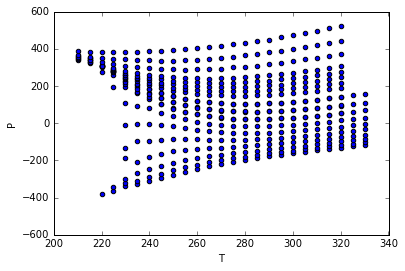

In [15]:
dfg = df.groupby('rho')
import matplotlib.pyplot as plt
fig, ax = plt.subplots()
for key,item in dfg:
    item.plot(x='T',y='P',ax=ax,marker='o',kind='scatter')
plt.show()

# need equation for spinodal for TIP5P